In [1]:
# importing sys
import sys

# adding Folder_2 to the system path
sys.path.insert(0, '/home/jeongeun/test_env/Open-Set-Object-Detection')

In [2]:
# AI2 THOR
!pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,depth2world
from ithor_tools.map2 import single_scenemap
from ithor_tools.landmark_utils import gather,gather3,vis_panorama,get_gt_box
from eval_ithor.objects import choose_query_objects,detect

from co_occurance.comet_co import co_occurance_score
import random
import math
# from IPython.display import display
# from moviepy.editor import ImageSequenceClip,VideoFileClip


# Planning Module
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing

from FBE.memory import fbe_map
from FBE.schedular import traj_schedular

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Detector module
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from structures.box import Boxes
from engine.predictor import DefaultPredictor

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from detector.postprocess import postprocess,plot_openset,plot_candidate

## Matching Module
from detector.query_matching import matcher

In [4]:
'''
config file
'''

print(torch.cuda.device_count())
torch.cuda.set_device(0)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('../Open-Set-Object-Detection/config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=19 #22
cfg.MODEL.RPN.USE_MDN=False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = True
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
cfg.MODEL.ROI_HEADS.AF = 'baseline'
cfg.MODEL.RPN.AUTO_LABEL = False
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'sum'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.UNCT = True
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2
cfg.PATH = '../Open-Set-Object-Detection'
cfg.phase = 'voc'
# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2
0


In [5]:
device = 'cuda:1'
model = GeneralizedRCNN(cfg,device = device).to(device)
state_dict = torch.load('../Open-Set-Object-Detection/ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location=device)
pretrained_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)

predictor = DefaultPredictor(cfg,model)

WARNING - 2022-06-21 22:56:47,881 - warnings - /home/jeongeun/test_env/Open-Set-Object-Detection/model/rpn/rpn.py:45: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)

WARNING - 2022-06-21 22:56:47,920 - warnings - /home/jeongeun/test_env/Open-Set-Object-Detection/model/rpn/rpn.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)



In [6]:
gridSize=0.05
scene_name = "FloorPlan_Val3_4"
controller = Controller(
    agentMode="locobot",
    platform=CloudRendering,
    visibilityDistance=1.5,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderClassImage = True,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

INFO - 2022-06-21 22:56:53,118 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


In [7]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderClassImage = True,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[100],
    rotation = dict(x=0,y=0,z=0)
)

pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
objects = controller.last_event.metadata['objects']

In [8]:
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


objectType                            objectId  \
0             Box            Box|+01.37|+00.24|-04.51   
1             Box            Box|+01.93|+00.30|-04.54   
2            Book           Book|+07.74|+00.89|-04.68   
3             Bed            Bed|+01.90|+00.00|-02.42   
4            Book           Book|+07.72|+00.92|-04.67   
5          Pillow         Pillow|+01.90|+00.68|-01.63   
6          Bottle         Bottle|+03.11|+00.89|-01.33   
7       FloorLamp      FloorLamp|+09.55|+00.00|-01.30   
8      BasketBall     BasketBall|+02.69|+00.12|-01.38   
9           Shelf          Shelf|+03.33|+00.88|-01.29   
10          Shelf          Shelf|+03.33|+00.55|-01.28   
11   TennisRacket   TennisRacket|+02.27|+00.61|-03.08   
12            Pot            Pot|+07.90|+00.11|-04.64   
13         Laptop         Laptop|+05.91|+00.33|-02.82   
14    BaseballBat    BaseballBat|+09.02|+00.68|-01.10   
15       DeskLamp       DeskLamp|+09.55|+00.48|-04.66   
16      FloorLamp      FloorLamp|+05.62|+00.00|-03.57   
17     Television     Television|+09.55|+01.28|-02.26   
18           Vase           Vase|+06.99|+00.47|-02.47   
19     GarbageCan     GarbageCan|+04.29|+00.00|-01.33   
20          Shelf          Shelf|+03.33|+00.17|-01.28   
21     HousePlant     HousePlant|+07.14|+00.47|-01.98   
22           Bowl           Bowl|+03.59|+00.19|-01.35   
23  RemoteControl  RemoteControl|+07.11|+00.48|-02.79   
24          Apple          Apple|+03.45|+00.63|-01.34   
25     AlarmClock     AlarmClock|+03.06|+00.56|-01.36   
26    SprayBottle     SprayBottle|+03.98|00.00|-01.43   
27            Mug            Mug|+03.66|+00.89|-01.31   
28   ShelvingUnit   ShelvingUnit|+03.33|+00.01|-01.28   
29    CoffeeTable     CoffeeTable|+07.13|00.00|-02.32   
30      SideTable      SideTable|+09.60|+00.00|-04.71   
31       Painting       Painting|+01.94|+01.42|-01.01   
32          Shelf          Shelf|+07.13|+00.28|-02.32   
33          Shelf          Shelf|+09.52|+00.20|-02.28   
34        TVStand         TVStand|+09.56|00.00|-02.28   
35          Shelf          Shelf|+09.52|+00.59|-02.28   
36          Floor          Floor|+00.00|+00.00|+00.00   
37          Shelf          Shelf|+08.11|+00.11|-04.70   
38         Drawer         Drawer|+08.58|+00.73|-04.48   
39      SideTable      SideTable|+08.15|+00.00|-04.68   
40         Drawer         Drawer|+07.72|+00.73|-04.48   
41           Sofa           Sofa|+05.70|+00.01|-02.27   
42       Painting       Painting|+06.40|+01.38|-01.01   
43       Painting       Painting|+08.11|+01.49|-04.90   

                           name  position[x]  position[y]  position[z]  \
0                        Box_16       1.3670       0.2404      -4.5120   
1                        Box_10       1.9340       0.2952      -4.5408   
2                       Book_28       7.7390       0.8871      -4.6790   
3                  Bed_09cf94c0       1.9000       0.0008      -2.4207   
4                       Book_29       7.7190       0.9170      -4.6719   
5                     pillow_29       1.9000       0.6821      -1.6308   
6                      Bottle_1       3.1104       0.8873      -1.3266   
7                  Floor_Lamp_9       9.5472       0.0001      -1.2981   
8                  Basketball_1       2.6870       0.1200      -1.3780   
9                     Shelf (2)       3.3250       0.8809      -1.2852   
10                    Shelf (3)       3.3250       0.5530      -1.2845   
11              Tennis_Racket_4       2.2680       0.6079      -3.0842   
12                       Pot_26       7.9010       0.1104      -4.6420   
13                     Laptop_4       5.9093       0.3268      -2.8175   
14                BaseballBat_4       9.0244       0.6837      -1.1000   
15                  Desk_Lamp_4       9.5460       0.4815      -4.6619   
16                Floor_Lamp_25       5.6164       0.0007      -3.5651   
17                 Television_4       9.5481       1.2806      -2.2631   
18                  Vase_Flat_2    

In [9]:
query_object = objects[2]

In [10]:
in_landmark_names = ['diningtable','sofa','tvmonitor']
out_landmark_names = ['desk','drawer','side table','coffee table','bed','arm chair']
landmark_names = in_landmark_names+out_landmark_names

In [11]:
landmark_cat = landmark_names
co_occurance_scoring = co_occurance_score('cuda:0')



model loading ...


INFO - 2022-06-21 22:57:00,248 - utils - using task specific params for summarization: {'early_stopping': True, 'length_penalty': 2.0, 'max_length': 24, 'min_length': 1, 'no_repeat_ngram_size': 3, 'num_beams': 4}


model loaded


In [12]:
co_occurance_scoring.landmark_init(landmark_cat)

In [13]:
co_occurance = co_occurance_scoring.score(query_object['objectType'])

WARNING - 2022-06-21 22:57:00,549 - warnings - /home/jeongeun/test_env/ITHOR_Navi/co_occurance/comet_co.py:41: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sims.append(doc1.similarity(doc2))



In [14]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)


In [28]:
scene_memory = fbe_map(scene_bounds,rstate,landmark_names=landmark_names, stepsize=0.1)
sche = traj_schedular(landmark_names,controller)
sche.set_score(co_occurance)

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789


In [16]:
clip_matcher = matcher(out_landmark_names,device='cuda:0')
clip_matcher.tokenize(query_object['objectType'])


In [26]:
controller.step(
    action="Teleport",
    position = rstate[100],
    rotation = dict(x=0,y=0,z=0)
)

<ai2thor.server.Event at 0x7efd33686bb0
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [18]:
from eval_ithor.reset import get_min_dis

min_dis = get_min_dis(query_object,controller,None,None)
print(min_dis)

4.33548011807258


In [19]:
rrtplanner = rrt.RRT(controller = controller, expand_dis=0.1,max_iter=10000,goal_sample_rate=20)
d2w = depth2world()

In [20]:
traj_image = controller.last_event.third_party_camera_frames[0]

In [21]:
detection_labels = []
for l in in_landmark_names:
    detection_labels.append(VOC_CLASS_NAMES.index(l))
print(detection_labels)

[10, 17, 19]


In [22]:
opos = query_object['position']

gt_vis? 0


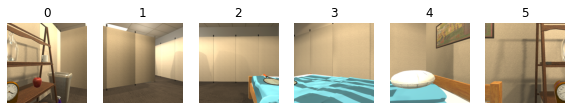

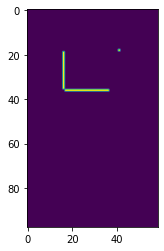

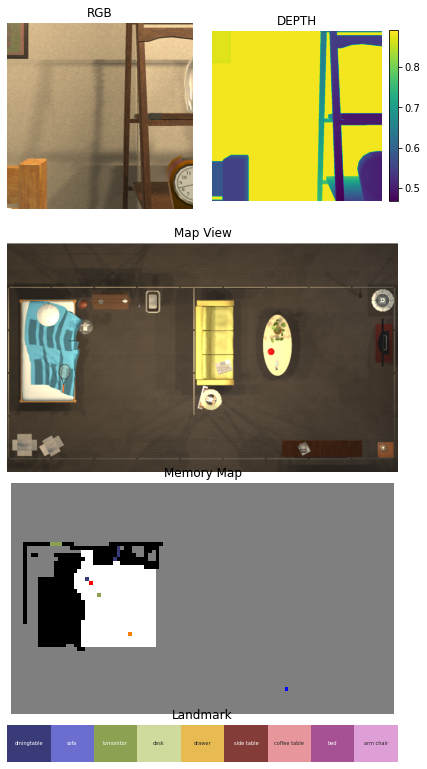

In [29]:
total_patch = np.zeros((0,256,256,3),dtype=np.uint8)
total_mappoints = []
total_success = 0
total_path_len = 0

frames,single_pos,gt_boxes,gt_vis,detected_landmarks = gather3(controller,[query_object['objectId']],opos,
                        predictor,postprocess,clip_matcher,detection_labels,scene_memory)
print('gt_vis?',gt_vis)
candidate_patches, candidate_map_points,sucesses = detect(frames,single_pos,gt_boxes,controller,predictor,clip_matcher,d2w)

total_patch = np.concatenate((total_patch,candidate_patches),axis=0)
total_mappoints += candidate_map_points
total_success += sucesses
vis_panorama(frames,res=360)
scene_memory.visited(controller)
landmark_config = dict(name=landmark_names,color = scene_memory.landmark_colors)
cpos = controller.last_event.metadata['agent']['position']
candidate_trajs = []
for l in detected_landmarks:
    res = scene_memory.get_reachable(cpos,l)
    if not res[0] == None:
        res = dict(name=l,pos=res[0],rot = res[1])
        candidate_trajs.append(res)
waypoints = scene_memory.frontier_detection(cpos)
candidate_trajs += waypoints


cpos = controller.last_event.metadata['agent']['position']
imshow_grid = scene_memory.plot(controller.last_event.metadata['agent']['position'],candidate_trajs,query_object['position'])
plot_frames2(controller.last_event,imshow_grid,landmark_config)     

In [30]:

NUM_WAYPOINT = 0
def draw_path(rrt,traj_image,path):
    traj_image = np.ascontiguousarray(traj_image, dtype=np.uint8)
    for idx in range(len(path)-1):
        prev_xz = rrt.rstate[path[idx]]
        next_xz = rrt.rstate[path[idx+1]]
        prev_w,prev_h = rrt.play_area.xz2coor(prev_xz[0],prev_xz[1])
        next_w,next_h = rrt.play_area.xz2coor(next_xz[0],next_xz[1])
        cv2.line(traj_image, (int(prev_w),int(prev_h)), (int(next_w),int(next_h)), (0,255,255), 2)
    # plt.imshow(traj_image)
    # plt.plot(path_wh[:,0], path_wh[:,1],'-c')

    # Cast start&end point coordinate in image
    # startx, startz = (rrt.start.x), (rrt.start.z)
    endx,   endz   = (rrt.end.x), (rrt.end.z)
    
    # startx, startz = rrt.play_area.xz2coor(startx, startz )
    endx,   endz   = rrt.play_area.xz2coor(endx,   endz   )
    
    # plt.plot(startx, startz,"xr")
    cv2.circle(traj_image, (int(endx),int(endz)), 5, (255,0,255), thickness=5)
    cv2.putText(traj_image, str(NUM_WAYPOINT), (int(endx),int(endz)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    # plt.plot(endx, endz, "xr")
    plt.imshow(traj_image)
    plt.show()
    return traj_image


[{'name': 'current', 'pos': {'x': 2.75, 'y': 0.9009996652603149, 'z': -1.9000000953674316}, 'rot': 0}, {'name': 'frontier', 'pos': {'x': 3.8000000000000003, 'y': 0.9009996652603149, 'z': -3.2000000000000006}, 'rot': None}]
start planning


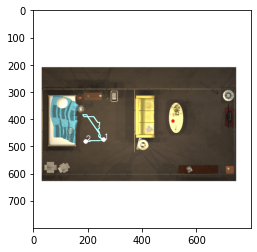

end planning
end move
MoviePy - Building file temp_1.gif with imageio.


gt_vis? 0


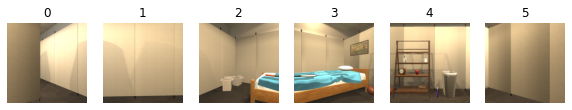

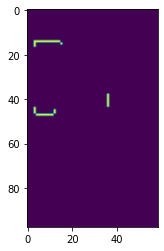

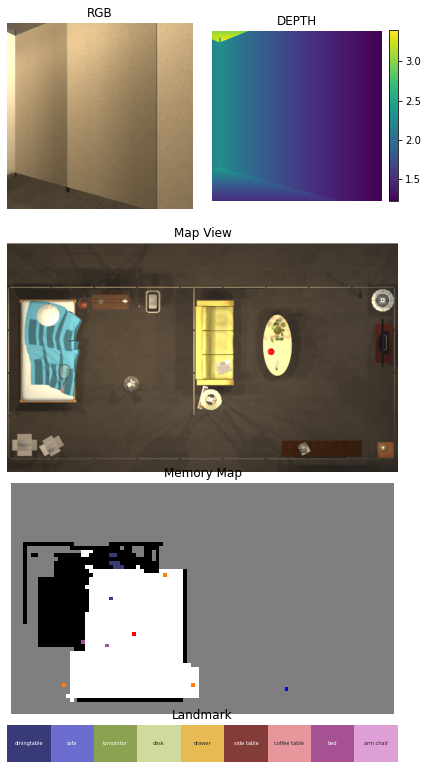

[{'name': 'current', 'pos': {'x': 3.8000001907348633, 'y': 0.9009996652603149, 'z': -3.200000286102295}, 'rot': 0}, {'name': 'bed', 'pos': {'x': 3.2, 'y': 0.9009996652603149, 'z': -3.500000000000001}, 'rot': 270.0}, {'name': 'frontier', 'pos': {'x': 4.7, 'y': 0.9009996652603149, 'z': -1.7000000000000006}, 'rot': None}]
start planning


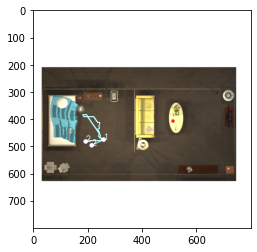

end planning
end move
MoviePy - Building file temp_2.gif with imageio.


True


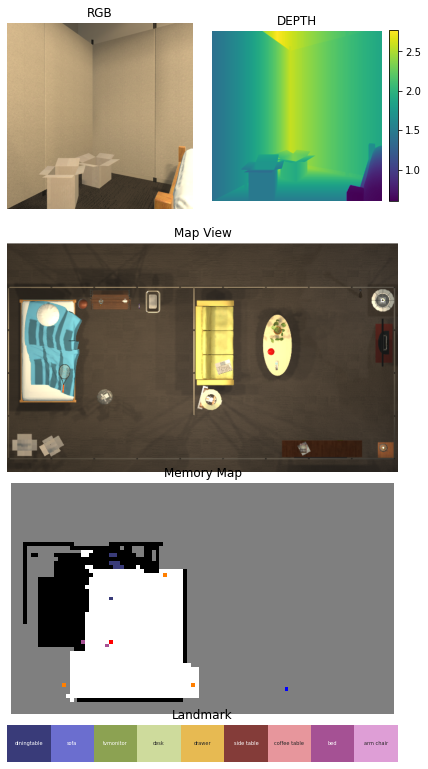

gt_vis? 0


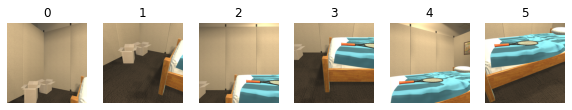

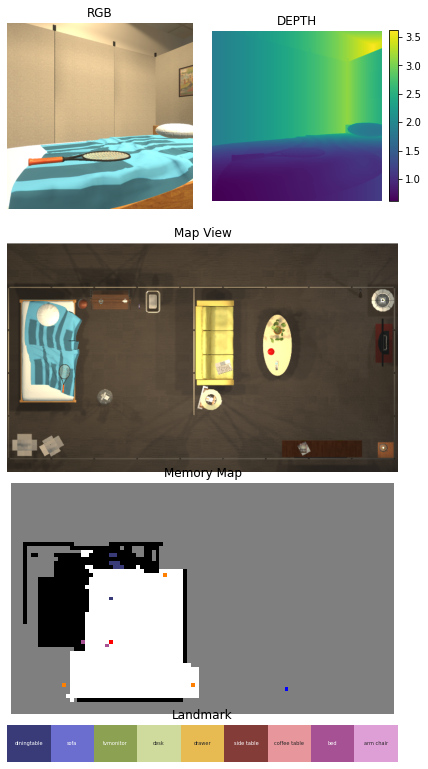

start planning


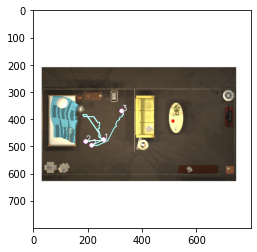

end planning
end move
MoviePy - Building file temp_3.gif with imageio.


gt_vis? 0


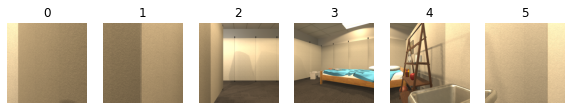

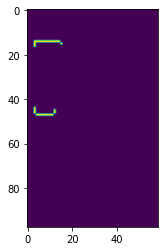

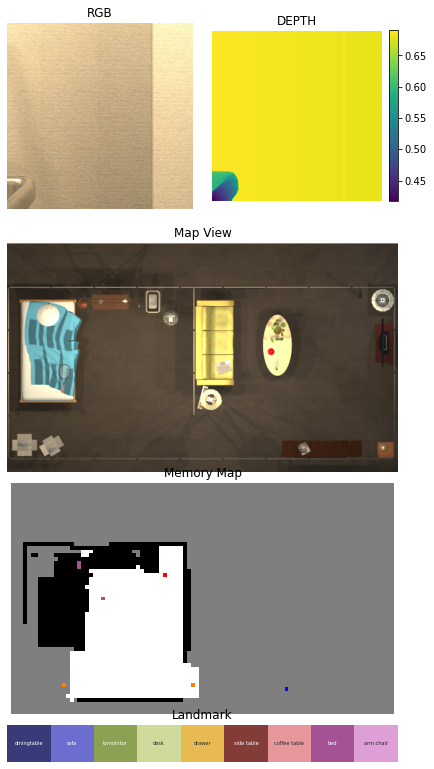

[{'name': 'current', 'pos': {'x': 4.699999809265137, 'y': 0.9009996652603149, 'z': -1.7000000476837158}, 'rot': 0}, {'name': 'frontier', 'pos': {'x': 5.300000000000001, 'y': 0.9009996652603149, 'z': -4.6000000000000005}, 'rot': None}]
start planning


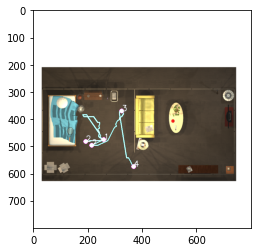

end planning
end move
MoviePy - Building file temp_4.gif with imageio.


2.4402685591586164
gt_vis? 0


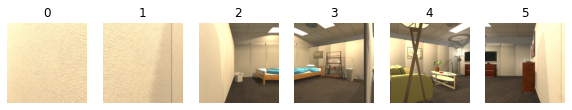

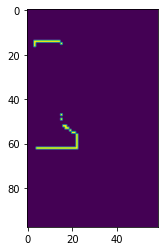

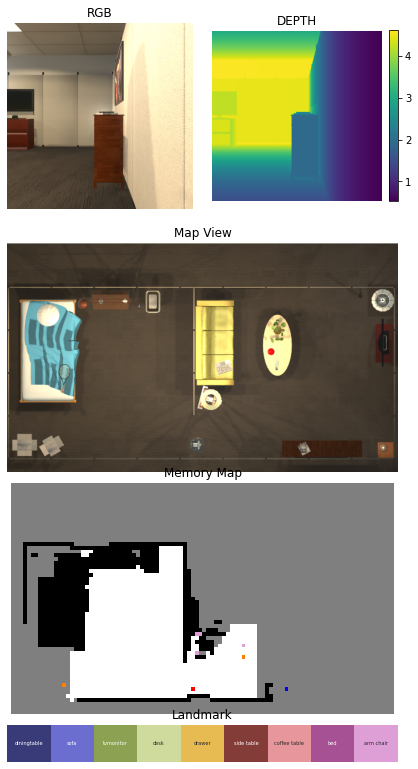

[{'name': 'current', 'pos': {'x': 5.300000190734863, 'y': 0.9009996652603149, 'z': -4.600000381469727}, 'rot': 0}, {'name': 'arm chair', 'pos': {'x': 6.7, 'y': 0.9009996652603149, 'z': -3.500000000000001}, 'rot': 270.0}, {'name': 'frontier', 'pos': {'x': 6.6000000000000005, 'y': 0.9009996652603149, 'z': -3.8000000000000007}, 'rot': None}]
start planning


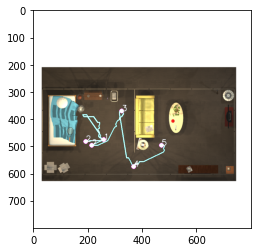

end planning
end move
MoviePy - Building file temp_5.gif with imageio.


True


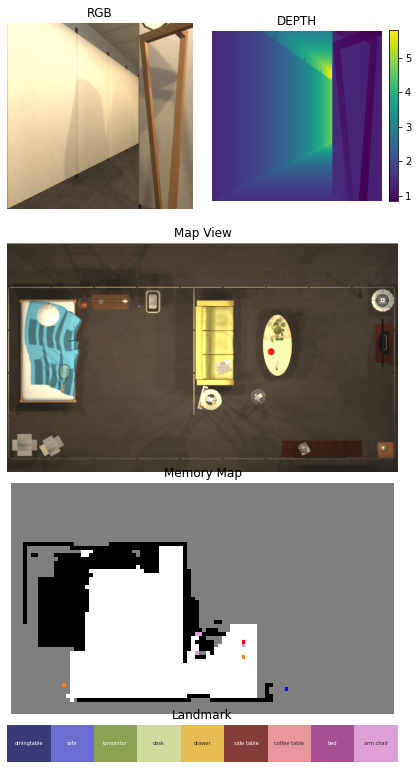

gt_vis? 0


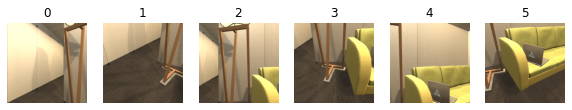

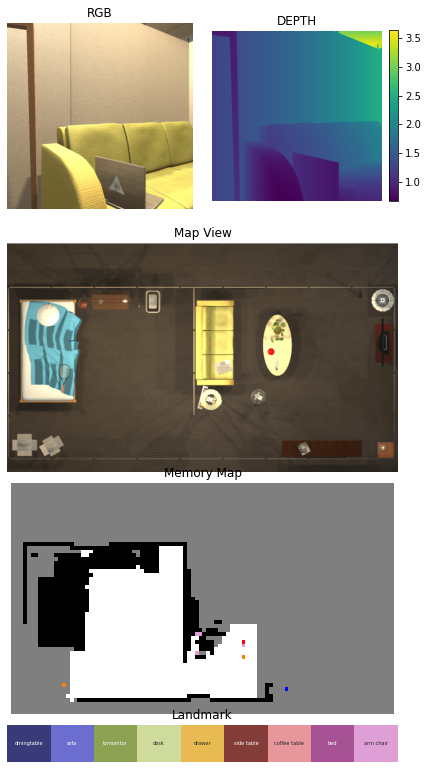

start planning


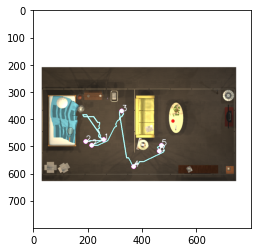

end planning
end move
MoviePy - Building file temp_6.gif with imageio.


1.4387334610594675
1.4387334610594675
gt_vis? 1


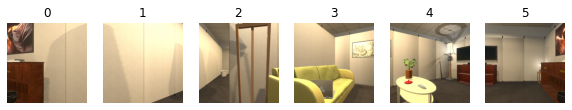

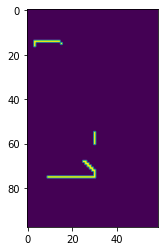

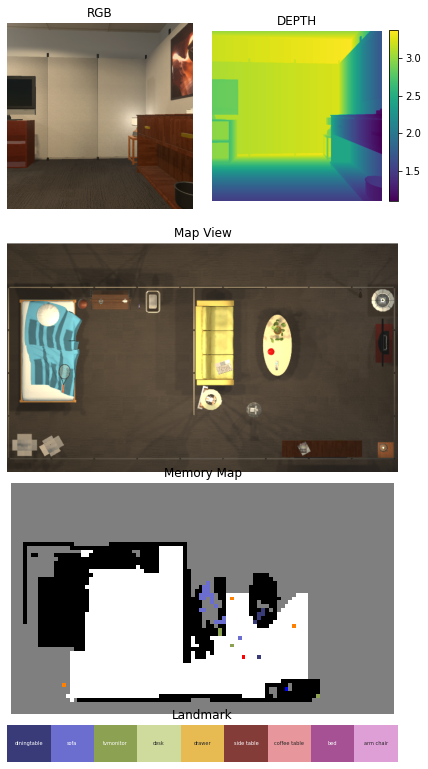

[{'name': 'current', 'pos': {'x': 6.600000381469727, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, {'name': 'frontier', 'pos': {'x': 6.4, 'y': 0.9009996652603149, 'z': -2.3000000000000007}, 'rot': None}]
start planning


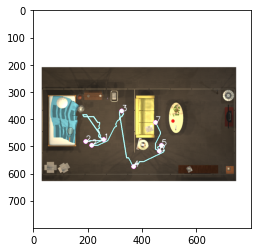

end planning
end move
MoviePy - Building file temp_7.gif with imageio.


2.729941299336296
gt_vis? 0


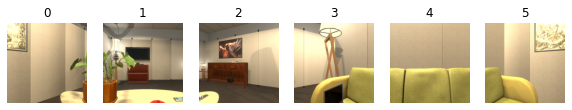

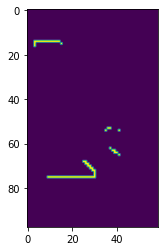

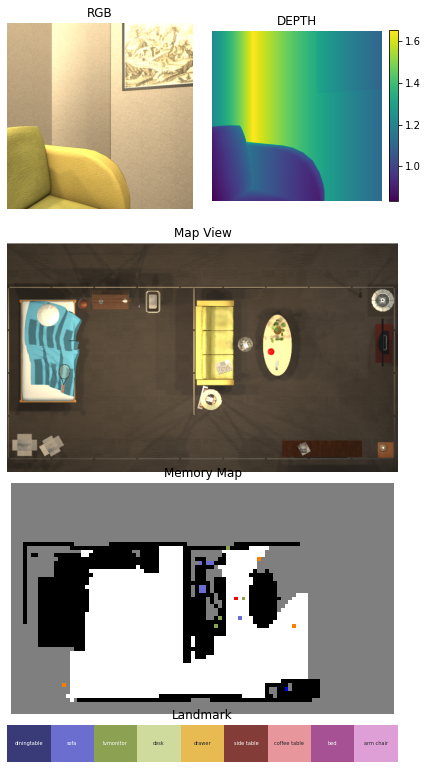

[{'name': 'current', 'pos': {'x': 6.400000095367432, 'y': 0.9009996652603149, 'z': -2.3000001907348633}, 'rot': 0}, {'name': 'sofa', 'pos': {'x': 6.500000000000001, 'y': 0.9009996652603149, 'z': -2.8000000000000007}, 'rot': 315.0}, {'name': 'frontier', 'pos': {'x': 7.000000000000001, 'y': 0.9009996652603149, 'z': -1.4000000000000004}, 'rot': None}]
start planning


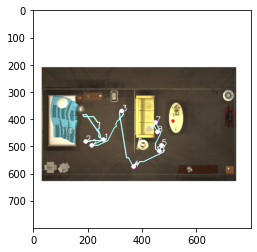

end planning
end move
MoviePy - Building file temp_8.gif with imageio.


True


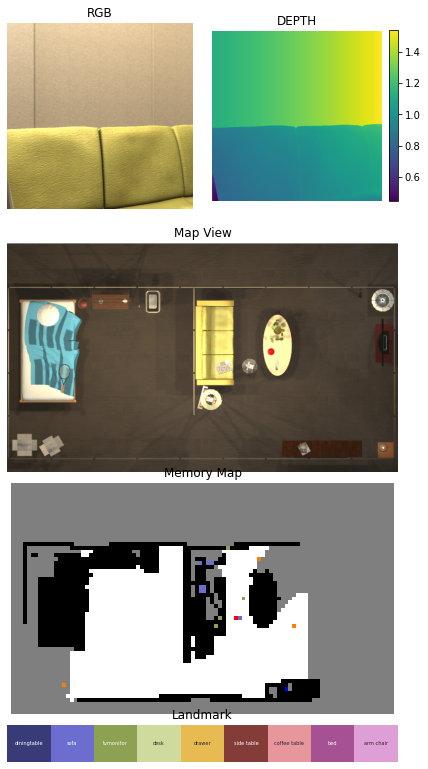

gt_vis? 0


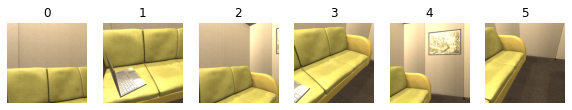

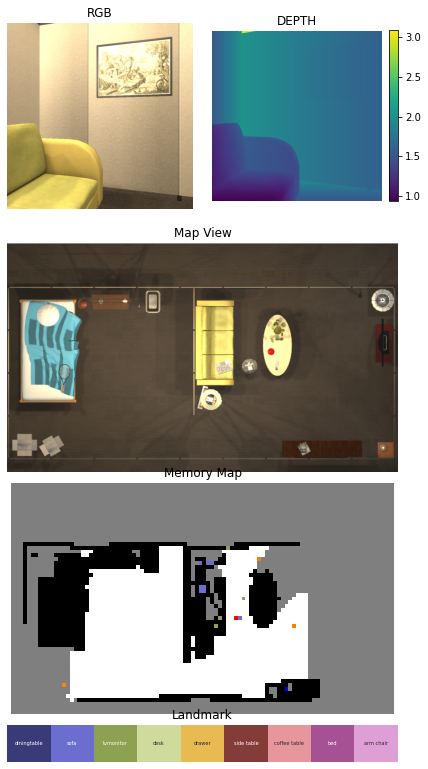

start planning


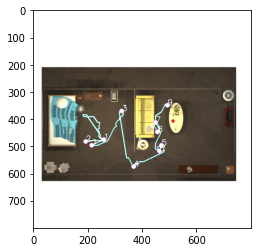

end planning
end move
MoviePy - Building file temp_9.gif with imageio.


gt_vis? 0


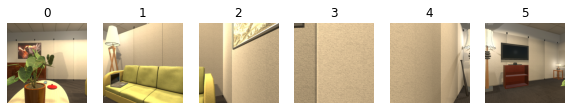

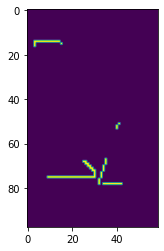

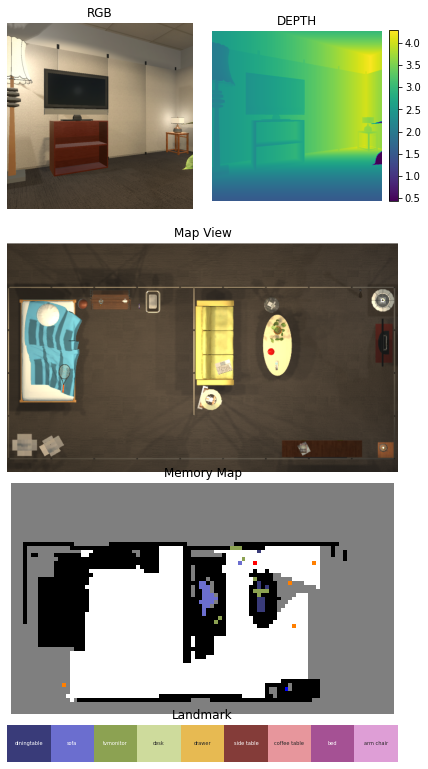

[{'name': 'current', 'pos': {'x': 7.0, 'y': 0.9009996652603149, 'z': -1.4000000953674316}, 'rot': 0}, {'name': 'sofa', 'pos': {'x': 6.500000000000001, 'y': 0.9009996652603149, 'z': -1.5000000000000004}, 'rot': 225.0}, {'name': 'frontier', 'pos': {'x': 7.9, 'y': 0.9009996652603149, 'z': -2.0000000000000004}, 'rot': None}]
start planning


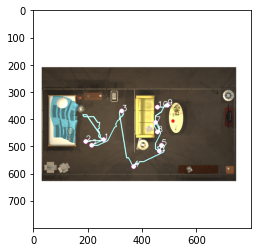

end planning
end move
MoviePy - Building file temp_10.gif with imageio.


True


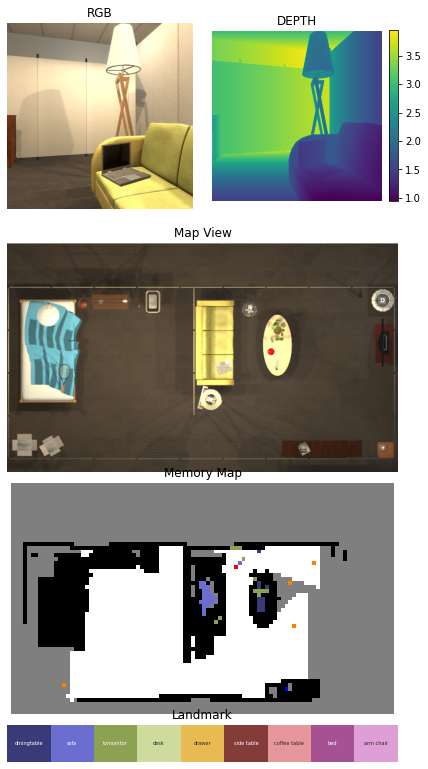

gt_vis? 0


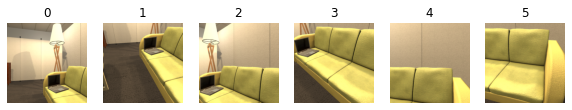

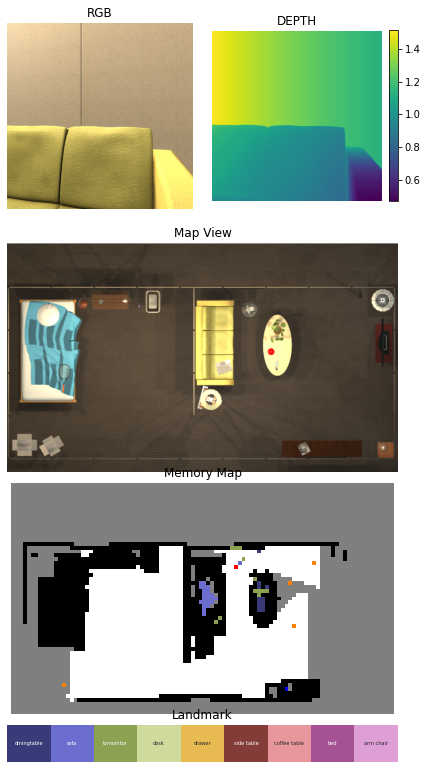

start planning


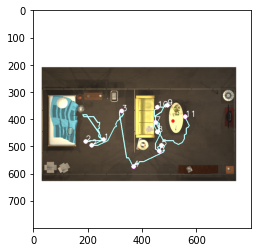

end planning
end move
MoviePy - Building file temp_11.gif with imageio.


2.683843993331875
gt_vis? 0


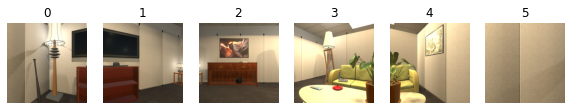

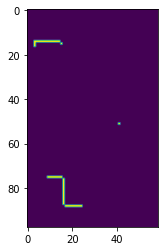

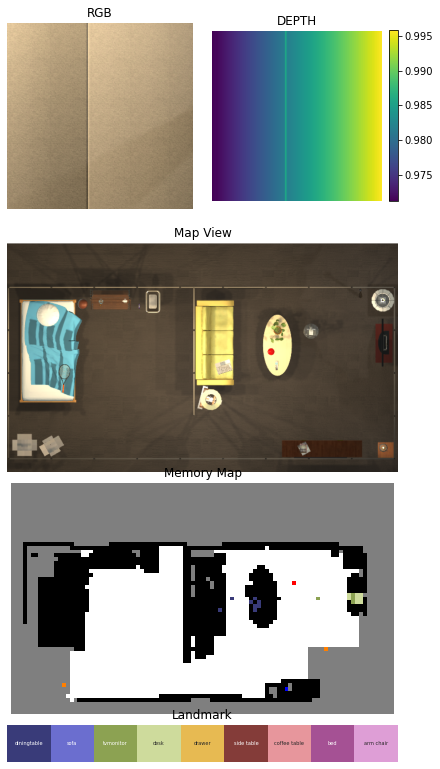

[{'name': 'current', 'pos': {'x': 7.900000095367432, 'y': 0.9009996652603149, 'z': -2.0}, 'rot': 0}, {'name': 'desk', 'pos': {'x': 8.6, 'y': 0.9009996652603149, 'z': -2.4000000000000004}, 'rot': 90.0}, {'name': 'frontier', 'pos': {'x': 8.799999999999999, 'y': 0.9009996652603149, 'z': -3.7000000000000006}, 'rot': None}]
start planning


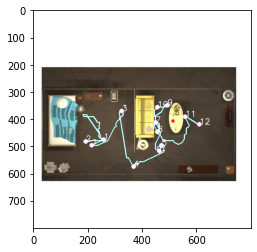

end planning
end move
MoviePy - Building file temp_12.gif with imageio.


True


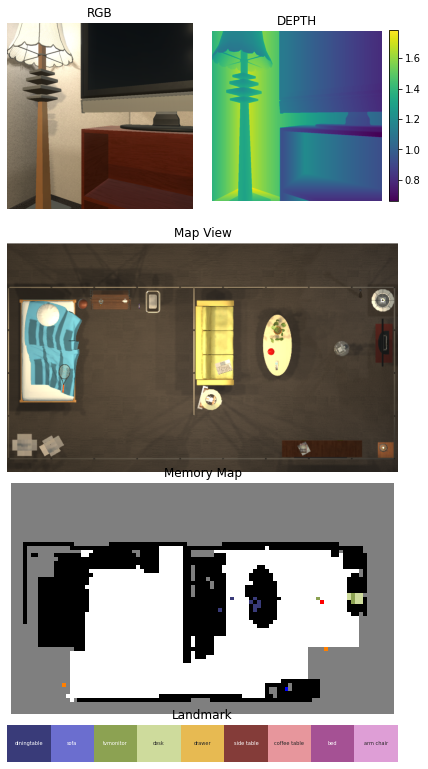

gt_vis? 0


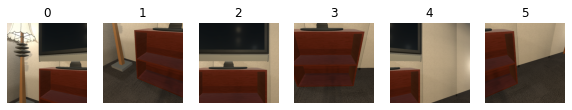

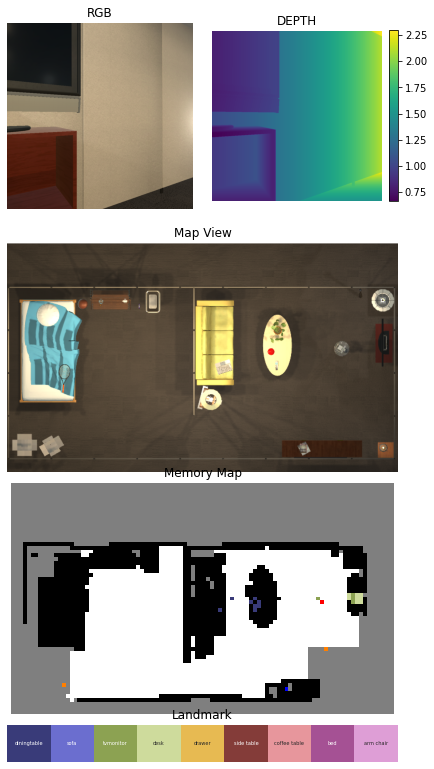

start planning


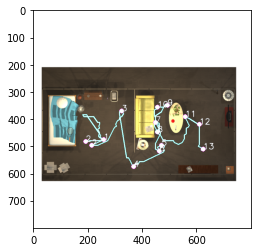

end planning
end move
MoviePy - Building file temp_13.gif with imageio.


1.4436771971964824
gt_vis? 1


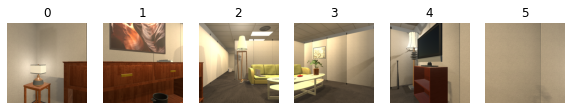

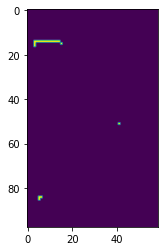

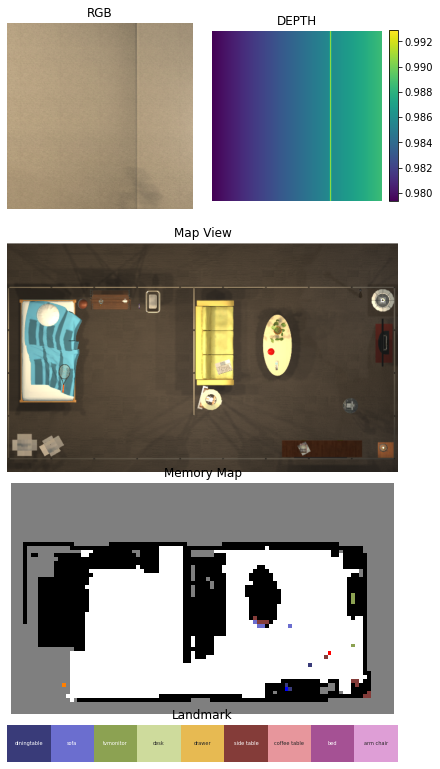

[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.700000286102295}, 'rot': 0}, {'name': 'side table', 'pos': {'x': 8.799999999999999, 'y': 0.9009996652603149, 'z': -3.8000000000000007}, 'rot': 225.0}, None]
start planning


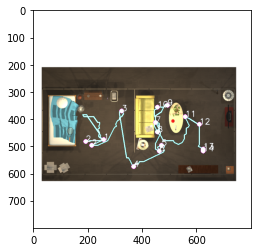

end planning
end move
MoviePy - Building file temp_14.gif with imageio.


True


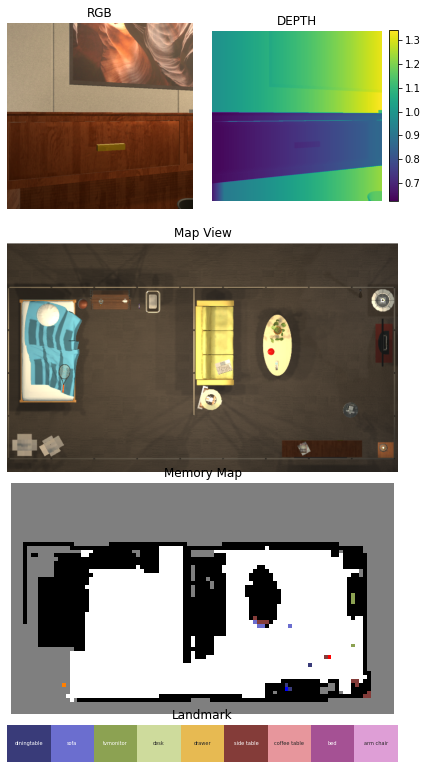

1.3778251310321283
1.3778251310321283
1.3778251310321283
gt_vis? 2


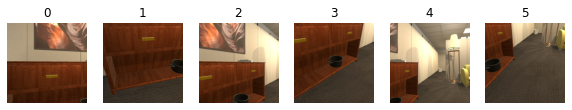

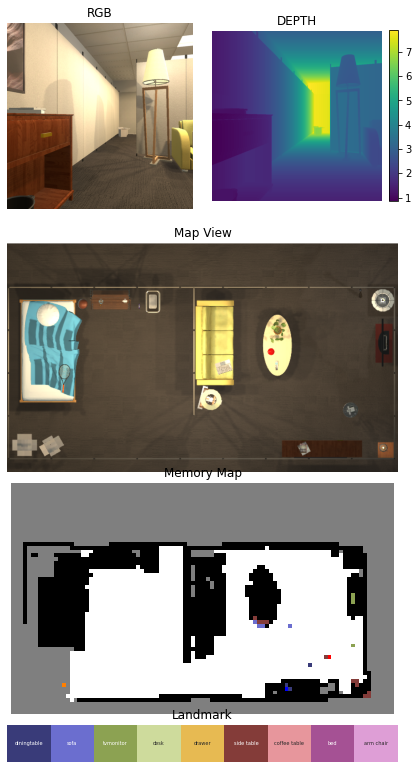

expolaration done
[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, None]
expolaration done
[{

WARNING - 2022-06-21 23:02:55,030 - warnings - /home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/ai2thor/controller.py:947: UserWarning: Restarting unity due to crash: Unity process has exited - check Player.log for errors. Last action message: b'{"action": "GetShortestPathToPoint", "position": {"x": 8.800000190734863, "y": 0.9009996652603149, "z": -3.8000001907348633}, "x": 2.1, "y": 0.9009996652603149, "z": -4.500000000000001, "allowedError": 0.1, "sequenceId": 774}', returncode=-11
  warnings.warn(message)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[{'name': 'current', 'pos': {'x': 8.800000190734863, 'y': 0.9009996652603149, 'z': -3.8000001907348633}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, 

WARNING - 2022-06-21 23:03:17,503 - warnings - /home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/ai2thor/controller.py:947: UserWarning: Restarting unity due to crash: Unity process has exited - check Player.log for errors. Last action message: b'{"action": "GetShortestPathToPoint", "position": {"x": 3.049999952316284, "y": 0.9009996652603149, "z": -1.9500000476837158}, "x": 2.1, "y": 0.9009996652603149, "z": -4.500000000000001, "allowedError": 0.1, "sequenceId": 199}', returncode=-11
  warnings.warn(message)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, None]
expolaration done
[{'name': 'current', 'pos': {'x': 3.049999952316284, 'y': 0.9009996652603149, 'z': -1.9500000476837158}, 'rot': 0}, 

In [31]:
angle = 200
step = 5
while not total_success:
    cpos = controller.last_event.metadata['agent']['position']
    path = sche.schedule(cpos,0,candidate_trajs)
    print(path)
    for p in path[1:]:
        if p == None:
            scene_memory.reset_gridmap()
            print('expolaration done')
            break
        # print(p)
        pos = controller.last_event.metadata['agent']['position']
        rrtplanner.set_start(pos)
        rrtplanner.set_goal(p['pos'])
        print("start planning")
        local_path = rrtplanner.planning(animation=False)
        try:
            smoothpath = smoothing.path_smoothing(rrtplanner,40,verbose=False)
        except:
            smoothpath = local_path
        to_pos = rrtplanner.rstate[smoothpath[-1]]
        # rrtplanner.plot_path(smoothpath)
        NUM_WAYPOINT +=1
        traj_image = draw_path(rrtplanner,traj_image,smoothpath)
        
        print("end planning")
        flag,path_len,frames = rrtplanner.go_with_teleport(smoothpath,maxspeed=0.2)
        print("end move")
        total_path_len += path_len
        
        video = ImageSequenceClip(frames, fps=10)
        video.write_gif('temp_{}.gif'.format(NUM_WAYPOINT))

        if p['name'] == 'frontier':
            # controller.step(
            # action="Teleport",
            # position = dict(x=to_pos[0],y=0.91,z=to_pos[1]), rotation = dict(x=0,y=0,z=0)
            #     )
            # print(controller.last_event.metadata['lastActionSuccess'])
            scene_memory.reset_landmark(detected_landmarks)
            frames,single_pos,gt_boxes,gt_vis,detected_landmarks = gather3(controller,[query_object['objectId']],opos,
                        predictor,postprocess,clip_matcher,detection_labels,scene_memory)
            print('gt_vis?',gt_vis)
            candidate_patches, candidate_map_points,sucesses = detect(frames,single_pos,gt_boxes,controller,predictor,clip_matcher,d2w)
            total_patch = np.concatenate((total_patch,candidate_patches),axis=0)
            total_mappoints += candidate_map_points
            total_success += sucesses
            vis_panorama(frames,res=360)

            scene_memory.visited(controller)
            landmark_config = dict(name=landmark_names,color = scene_memory.landmark_colors)
            cpos = controller.last_event.metadata['agent']['position']
            candidate_trajs = []
            for l in detected_landmarks:
                res = scene_memory.get_reachable(cpos,l)
                if not res[0] == None:
                    res = dict(name=l,pos=res[0],rot = res[1])
                    candidate_trajs.append(res)
            waypoints = scene_memory.frontier_detection(cpos)
            candidate_trajs += waypoints
        else:
            pos = controller.last_event.metadata['agent']['position']
            controller.step(
                action="Teleport",
                position = pos, rotation = dict(x=0,y=p['rot']-angle/2,z=0)
                    )
            print(controller.last_event.metadata['lastActionSuccess'])
            imshow_grid = scene_memory.plot(controller.last_event.metadata['agent']['position'],candidate_trajs,query_object['position'])
            plot_frames2(controller.last_event,imshow_grid,landmark_config)
            frames, single_pos,gt_boxes,gt_vis = gather(controller,[query_object['objectId']],opos,step=step,angle=angle)
            print('gt_vis?',gt_vis)
            candidate_patches, candidate_map_points,sucesses = detect(frames,single_pos,gt_boxes,controller,predictor,clip_matcher,d2w)
            total_patch = np.concatenate((total_patch,candidate_patches),axis=0)
            total_mappoints += candidate_map_points
            total_success += sucesses
            vis_panorama(frames,res=angle)
            
        cpos = controller.last_event.metadata['agent']['position']
        imshow_grid = scene_memory.plot(controller.last_event.metadata['agent']['position'],candidate_trajs,query_object['position'])
        plot_frames2(controller.last_event,imshow_grid,landmark_config)  
        if total_success:
            break      


In [1]:

cpos = controller.last_event.metadata['agent']['position']
imshow_grid = scene_memory.plot(controller.last_event.metadata['agent']['position'],candidate_trajs,query_object['position'])
plot_frames2(controller.last_event,imshow_grid,landmark_config)  

print("Sucess?",total_success>0)
print("Total Path Length", total_path_len)
SPL = (total_success>0)*min_dis/total_path_len
print("SPL:",SPL )
plot_candidate(total_patch,total_mappoints,query_object['objectType'],scene_memory)

NameError: name 'controller' is not defined

In [ ]:
controller.stop_unity()